In [ ]:
# Installation cell
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

In [ ]:
#Julia 1.3 Environment
using Pkg
pkg"add BenchmarkTools; precompile;"
pkg"add CuArrays; precompile;"

In [8]:
import Pkg; Pkg.add("CUDAdrv")
using CUDAdrv; CUDAdrv.name(CuDevice(0))

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
  [c5f51814] + CUDAdrv v6.3.0
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


"Tesla P100-PCIE-16GB"

In [ ]:
import Pkg; Pkg.add("FFTW")
using FFTW
using BenchmarkTools
using CuArrays
CuArrays.allowscalar(false)


In [23]:

import Pkg; Pkg.add("PyPlot")
import Pkg; Pkg.add("PyCall")
using PyPlot
using PyCall


 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


In [24]:
"""
Make Bsites for 1D Heisenberg\n
Nsites - the number of sites
"""
function makeBsites(Nsites)
    bsites = zeros(Int,Nsites-1,2)
    bsites[:,1] = 1:Nsites-1
    bsites[:,2] = 2:Nsites
    return bsites
end


makeBsites

In [26]:
import Pkg; Pkg.add("TimerOutputs")
using TimerOutputs

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
  [a759f4b9] + TimerOutputs v0.5.5
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


In [15]:
import Random

"""
Get diag update addition probability
"""
function diagProbAdd(B,β,M,n)
    return (min((B*β/2)/(M-n),1))
end

"""
Get diag update removal probability
"""
function diagProbRemove(B,β,M,n)
    return (min((M-n+1)/(B*β/2),1))
end

#Random.seed!(1234)
"""
Return a random number [0,1)
"""
function getRand()
    return rand()
end

"""
The function that implements diagonal update\n
a - bond type
b - bond id
opstring - combind bond type and id
spin - the spin configuration
bsites - site list for each bond
MaxM - the time dimension
Nsites - number of sites
β - time step
"""
function diagUpdate!(a,b,opstring,spin,bsites,n,MaxM,Nsites,β)
    B = Nsites-1
    for i in 1:MaxM
        rnd = getRand()
        bnd = trunc(Int,ceil(B*rnd))
        spin1 = spin[trunc(Int,bsites[bnd,1])]
        spin2 = spin[trunc(Int,bsites[bnd,2])]
        if spin1 != spin2 && a[i] == 0
            probAc = diagProbAdd(B,β,MaxM,n)
#             print(probAc,"\n")
            rnd = getRand()
            if rnd < probAc
                # accept update
                b[i] = bnd
                a[i] = 1
                opstring[i] = 2 * bnd
                n += 1
            end
        elseif a[i] == 1
            probRm = diagProbRemove(B,β,MaxM,n)
            rnd = getRand()
#             print(probRm,"\n")
            if rnd < probRm
                # remove bond
                b[i] = 0
                a[i] = 0
                opstring[i] = 0
                n -= 1
            end
        end
        if a[i] == 2
            # propagate the state
            spin[trunc(Int,bsites[trunc(Int,b[i]),1])] *=-1
            spin[trunc(Int,bsites[trunc(Int,b[i]),2])] *=-1
        end
    end
    return n
end

diagUpdate!

In [16]:
"""
A function that combines two lists and returns a sorted list.
"""
function mergesorted(a,b) 
    return(sort!(vcat(a,b)))
end


"""
A simple version to make the vertex list
we simply combine the off-diagonal and diagonal terms.
a - the bond types
b - the bond ids of each bond
"""
function makeVertexListSimple(a,b,bsites,Nsites,M)
    # Get the dimension
    MaxM = M
#    print("MaxM=",MaxM,"\n")
    
    # find the number of operators
    # and their locations
    op_ids = findall(x->x > 0,a)
    num_op = size(op_ids)[1]

    # get bond corresponding to each operator
    bond_op = b[op_ids]

    # get bond type
    bond_type = a[op_ids] 
    
    cyclic_ids = Dict()
    for i in 1:Nsites-1
        cyclic_ids[i] = i
    end
    cyclic_ids[Nsites] = -1
    cyclic_ids[0] = -1
    
    vlist = zeros(Int,MaxM,4)
    
    boolToId_prev = Dict()
    boolToId_prev[true]  = 3
    boolToId_prev[false] = 4
    
    boolToId_next = Dict()
    boolToId_next[true]  = 4
    boolToId_next[false] = 3
    
    lpNext = Dict()
    lpNext[3] = 1
    lpNext[4] = 2
    
    done_prev = false
    done_next = false

    
    # list of bonds that are crossed 
    # due to the periodic loops
    crossed_bonds = zeros(Int,Nsites-1)
    
    # Spins that are wound around
    crossed_spins = zeros(Int,Nsites)
    
    idxcrossbond_prev = Dict()
    idxcrossbond_prev[true] = 0
    idxcrossbond_prev[false] = -1
    
    idxcrossbond_next = Dict()
    idxcrossbond_next[true] = 0
    idxcrossbond_next[false] = 1
    
    checkIds = Dict()
    for i in 1:Nsites-1
        checkIds[i] = i
    end    
    checkIds[0] = 1
    checkIds[Nsites] = Nsites-1    
    
    
    # make the list of op ids which act on bond ids
    # one before and one after the current bond id
    # e.g.
    # -a-|
    #    |
    #    |    |-b-
    #    |-e--|
    #    |    |
    #    1    2
    #     ----
    #    3    4
    #    |    |
    # -c-|    |
    #    |    |-d-
    #    |-f--|
    #
    # the stored indices will be [1,2,4,5] each for the
    # four legs
#    diff_bond_list = zeros(num_op,4)
    for i in 1:num_op
        p = op_ids[i]   
        
        done_prev = false
        done_next = false
        
        bid_i = trunc(Int,bond_op[i])
        bid_im1 = cyclic_ids[bid_i - 1]
        bid_ip1 = cyclic_ids[bid_i + 1]
        
        diag_idlist = filter!(x->x != i,findall(x->x == bid_i, bond_op))
        prev_idlist = findall(x->x == bid_im1, bond_op)
        next_idlist = findall(x->x == bid_ip1, bond_op)
        
        blist_prev = mergesorted(prev_idlist,diag_idlist)
        nbids_prev = size(blist_prev)[1]
        blist_next = mergesorted(diag_idlist,next_idlist)
        nbids_next = size(blist_next)[1]
        
        if nbids_prev == 0
            blist_prev = [i]
            ids_adjascent_prev = [1]
            nbids_prev = 1
            done_prev = true
            # set the crossed bonds index
            crossed_bonds[checkIds[b[p]]] += 1
            bnd = checkIds[b[p]]
            crossed_spins[bsites[bnd,1]] = 1
        end
        if nbids_next == 0
            blist_next = [i]
            ids_adjascent_next = [1]
            nbids_next = 1
            done_next = true
            # set the crossed bonds index
            crossed_bonds[checkIds[b[p]]] += 1
            bnd = checkIds[b[p]]
            crossed_spins[bsites[bnd,2]] = 1
        end

        if !done_prev
            ids_adjascent_prev = [searchsortedlast(blist_prev,i),searchsortedfirst(blist_prev,i)]
        
            # adjust for the case where i is at 0 or end
            if ids_adjascent_prev[1] == 0 || ids_adjascent_prev[2] == nbids_prev + 1
                if nbids_prev == 1
                    ids_adjascent_prev = [1]
                    nbids_prev = 1
                else
                    ids_adjascent_prev = [nbids_prev,1]
                    nbids_prev = 2
                end
                
                # set the crossed bonds index
                if i > blist_prev[1]
                    crossbid = idxcrossbond_prev[isinvec(diag_idlist, blist_prev[1])]
                    crossed_bonds[checkIds[b[p] + crossbid]] += 1
                else
                    crossbid = idxcrossbond_prev[isinvec(diag_idlist, blist_prev[end])]
                    crossed_bonds[checkIds[b[p] + crossbid]] += 1                    
                end
                
                # Set the crossed spin at prev
                bnd = checkIds[b[p]]
                crossed_spins[bsites[bnd,1]] = 1
            end
        end
        if !done_next
            ids_adjascent_next = [searchsortedlast(blist_next,i),searchsortedfirst(blist_next,i)]
        
            # adjust for the case where i is at 0 or end
            if ids_adjascent_next[1] == 0 || ids_adjascent_next[2] == nbids_next + 1
                if nbids_next == 1
                    ids_adjascent_next = [1]
                    nbids_next = 1
                else
                    ids_adjascent_next = [nbids_next,1]
                    nbids_next = 2
                end
                # set the crossed bonds index
                if i > blist_next[1]
                    crossbid = idxcrossbond_next[isinvec(diag_idlist, blist_next[1])]
                    crossed_bonds[checkIds[b[p] + crossbid]] += 1
                else
                    crossbid = idxcrossbond_next[isinvec(diag_idlist, blist_next[end])]
                    crossed_bonds[checkIds[b[p] + crossbid]] += 1                    
                end            
                
                # Set the crossed spin at next
                bnd = checkIds[b[p]]
                crossed_spins[bsites[bnd,2]] = 1
            end
        end

        
#        print(i,"\t",bid_im1,"\t",bid_i,"\t",bid_ip1,"\t",blist_prev,"\t",blist_next,"\n")
#        print("\t>",ids_adjascent_prev,"\t",nbids_prev,"\n")
#        print("\t>",ids_adjascent_next,"\t",nbids_next,"\n")
        
        
        # assign left ids to vertexlist
        if nbids_prev == 1
            pid_prev = blist_prev[ids_adjascent_prev[1]]
            p_id = op_ids[pid_prev]
            if isinvec(diag_idlist,pid_prev) || pid_prev == i
                vlist[p,1] = 4*(p_id - 1) + 3
                vlist[p,3] = 4*(p_id - 1) + 1
            else
                vlist[p,1] = 4*(p_id - 1) + 4
                vlist[p,3] = 4*(p_id - 1) + 2              
            end
        else
            pid_left_up = blist_prev[ids_adjascent_prev[1]]
            p_id_up = op_ids[pid_left_up]
            pid_left_dn = blist_prev[ids_adjascent_prev[2]]
            p_id_dn = op_ids[pid_left_dn] 
            
            # get lp
            lp_up = boolToId_prev[isinvec(diag_idlist,pid_left_up)]
            lp_dn = lpNext[boolToId_prev[isinvec(diag_idlist,pid_left_dn)]]
            
            # set vlist
            vlist[p,1] = 4*(p_id_up - 1) + lp_up
            vlist[p,3] = 4*(p_id_dn - 1) + lp_dn
        end
        
        # assign right ids to vertexlist
        if nbids_next == 1
            pid_next = blist_next[ids_adjascent_next[1]]
            p_id = op_ids[pid_next]
            if isinvec(diag_idlist,pid_next) || pid_next == i
                vlist[p,2] = 4*(p_id - 1) + 4
                vlist[p,4] = 4*(p_id - 1) + 2
            else
                vlist[p,2] = 4*(p_id - 1) + 3
                vlist[p,4] = 4*(p_id - 1) + 1              
            end
        else
            pid_right_up = blist_next[ids_adjascent_next[1]]
            p_id_up = op_ids[pid_right_up]
            pid_right_dn = blist_next[ids_adjascent_next[2]]
            p_id_dn = op_ids[pid_right_dn] 
            
            # get lp
            lp_up = boolToId_next[isinvec(diag_idlist,pid_right_up)]
            lp_dn = lpNext[boolToId_next[isinvec(diag_idlist,pid_right_dn)]]
            
            # set vlist
            vlist[p,2] = 4*(p_id_up - 1) + lp_up
            vlist[p,4] = 4*(p_id_dn - 1) + lp_dn
        end

    end
    return (vlist, crossed_bonds, crossed_spins)
end

makeVertexListSimple

In [40]:

"""
Construct all loops given vlist
vlist - the vertexlist
"""
function constructAllLoops(vlist,crossed_bonds,crossed_spins,bsites,MaxM)
    
    
    # Dict to check if bond is wound around
    iscrossed = Dict()
    # v2 - v1, Pair(l1,l2)
    # 3
    # |
    # .
    # 1
    iscrossed[Pair( 1,Pair(3,1))] = false
    # 1
    # .
    # |
    # 3
    iscrossed[Pair(-1,Pair(3,1))] = true
    # 4
    # |
    # .
    # 2
    iscrossed[Pair( 1,Pair(4,2))] = false
    # 2
    # .
    # |
    # 4
    iscrossed[Pair(-1,Pair(4,2))] = true
    # 3
    # .
    # |
    # 1
    iscrossed[Pair(-1,Pair(1,3))] = false
    # 1
    # |
    # .
    # 3
    iscrossed[Pair( 1,Pair(1,3))] = true
    # 4
    # .
    # |
    # 2
    iscrossed[Pair(-1,Pair(2,4))] = false
    # 2
    # |
    # .
    # 4
    iscrossed[Pair( 1,Pair(2,4))] = true
    # 1
    # |
    # .
    # 4
    iscrossed[Pair(-1,Pair(1,4))] = false
    # 4
    # .
    # |
    # 1
    iscrossed[Pair( 1,Pair(1,4))] = true
    # 2
    # |
    # .
    # 3
    iscrossed[Pair(-1,Pair(2,3))] = false
    # 3
    # .
    # |
    # 2
    iscrossed[Pair( 1,Pair(2,3))] = true
    # 2
    # .
    # |
    # 3
    iscrossed[Pair(-1,Pair(3,2))] = true
    # 3
    # |
    # .
    # 2
    iscrossed[Pair( 1,Pair(3,2))] = false
    # 1
    # .
    # |
    # 4
    iscrossed[Pair(-1,Pair(4,1))] = true
    # 4
    # |
    # .
    # 1
    iscrossed[Pair( 1,Pair(4,1))] = false
#    print(iscrossed,"\n")

    crossed_spins_ret = deepcopy(crossed_spins)
    traversedvertices = ones(Int,MaxM, 4)
    zerosid = findall(x->x == 0,vlist)
    traversedvertices[zerosid] .= 0
    loops = []
    loops_nonoverlapping = []
    list_crossed_sites_per_loop = []
    crossed_sites_per_loop = zeros(Int,Nsites)
    nones = MaxM*4
    nonzerosid = findall(x->x != 0,vlist)
    if size(nonzerosid)[1] > 0
        
        v1 = vlist[nonzerosid[1]]
        
        lpmove = Dict()
        lpmove[0]=4
        lpmove[1]=1
        lpmove[2]=2
        lpmove[3]=3
        
        bond_pos = Dict()
        bond_pos[1] = 1
        bond_pos[3] = 1
        bond_pos[2] = 2
        bond_pos[4] = 2

        lp = lpmove[v1%4]
        p  = trunc(Int,1 + (v1-lp)/4)
        while nones > 0
            bids, legids, listp, listlp = findLoops(vlist,p,lp);
#            print("===\n")
#            print(legids,"\n")
#            print("===\n")
            push!(loops,legids)
            for (a,b) in zip(listp[1:end-1],listlp[1:end-1])
                @inbounds traversedvertices[a,b] *= -1
            end
            
            traversedvertices_cu = cu(traversedvertices)
            combinds = map(x->(x[1]:x[1],x[2]:x[2]),collect(zip(listp[1:end-1],listlp[1:end-1])))
            CuArrays.@sync map(x->traversedvertices_cu[x...]*=-1,combinds)

            idones = findall(x->x==1,traversedvertices)
            nones = size(idones)[1]
            if nones > 0
                p = idones[1][1]
                lp = idones[1][2]
            end
        end
        
        # Remove overlapping paths
        donep1 = zeros(Int,size(a))
        nloops = size(loops)
        loopdims = map(x->size(x)[1],loops)
        idxloops = findall(x->x>0,loopdims)
        idxsorted = sortperm(loopdims,rev=true)
        numloops = size(idxloops)[1]
        for i in 1:numloops
            id = idxsorted[i]
#            print("loop : ",id,"\n")
#            print(loops[id],"\n")
            keeploop = true;
            vprev = -1
            lpprev = -1
            pprev = -1
            tmp_crossed_spins = deepcopy(crossed_spins_ret)
            crossed_sites_per_loop = zeros(Int,Nsites)
            for j in 1:loopdims[id]
                v1  = loops[id][j]
                lp1 = lpmove[v1%4]
                p1  = trunc(Int,1 + (v1-lp1)/4)   
                bnd = b[p1]
#                print(p1,"\t",lp1,"\n")
                if donep1[p1] > 0
                    keeploop = false
                    # remove bond crossing
                    if crossed_bonds[bnd] > 0
                        crossed_bonds[bnd] -= 2                       
                    end
                end
#                keeploop = true
#                    print(j," ",p1,"\t lp1=",lp1,"\t",bnd,"\t lpprev=",lpprev,"\n")
                # Check if bond is wound around
                if j == 1
                    vprev = v1
                    lpprev = lp1
                    pprev = p1
                elseif haskey(iscrossed,Pair(sign(v1-vprev),Pair(lpprev,lp1)))
#                        print(Pair(v1,lp1)," ",p1,"\t",Pair(vprev,lpprev)," ",pprev,"\n")
#                        print(iscrossed[Pair(sign(v1-vprev),Pair(lpprev,lp1))],"\t leg=",bond_pos[lp1],"\n")
                    if iscrossed[Pair(sign(v1 - vprev),Pair(lpprev,lp1))]
                        tmp_crossed_spins[bsites[bnd,bond_pos[lp1]]] -= 1
                        crossed_sites_per_loop[bsites[bnd,bond_pos[lp1]]] = 1
                    end
                    vprev = v1
                    lpprev = lp1
                    pprev = p1
                else
                    vprev = v1
                    lpprev = lp1
                    pprev = p1
                end
            end
#            print(tmp_crossed_spins," ====>> ",keeploop,"\n")
            if keeploop
                push!(loops_nonoverlapping,loops[id])
                push!(list_crossed_sites_per_loop,crossed_sites_per_loop)
            else
                crossed_spins_ret = deepcopy(tmp_crossed_spins)
            end
#            print(crossed_spins_ret," ====>> ",keeploop,"\n")
            for j in 1:loopdims[id]-1
                v1  = loops[id][j]
                lp1 = lpmove[v1%4]
                p1  = trunc(Int,1 + (v1-lp1)/4)   
#                 print(p1,"\n")
                donep1[p1] += 1
            end
        end
#         print("------\n")
#         print(loops_nonoverlapping,"\n")
#         print(loops,"\n")
#         print("-------\n")
        return(loops_nonoverlapping, list_crossed_sites_per_loop)
    else
        return(-1)
    end
end

constructAllLoops

In [18]:
"""
Generate the list of all the pair of operators with loop dim  > 5 for 
the loop update
looplist - list of loops
a - list of bond types
b - list of bond ids
opstring - opstring
bsites - spin ids for each bond
"""
function loopUpdate!(looplist,a,b,opstring,spin,bsites,crossed_bonds,list_crossed_sites_per_loop)
    
    lpmove = Dict()
    lpmove[0]=4
    lpmove[1]=1
    lpmove[2]=2
    lpmove[3]=3
    
    opinvert = Dict()
    opinvert[1] = 2
    opinvert[2] = 1
        
    bond_pos = Dict()
    bond_pos[1] = 1
    bond_pos[3] = 1
    bond_pos[2] = 2
    bond_pos[4] = 2
    
    donea = zeros(Int,size(a))
#    print(crossed_bonds,"\n")
#     print(looplist,"\n")
            
    nloops = size(looplist)
#     print("nloops=",nloops,"\n")
    loopdims = map(x->size(x)[1],looplist)
    idxloops = findall(x->x>0,loopdims)
    numloops = size(idxloops)[1]
    for i in 1:numloops
        id = idxloops[i]
        rnd = getRand()
#         print("======\n",looplist[id],"\n")
        if rnd > 0.5
#            print("Flipping\n")
#            print(looplist[id],"\n")
            crossed_spins = list_crossed_sites_per_loop[id]
            for j in 1:loopdims[id]-1
                v1  = looplist[id][j]
                lp1 = lpmove[v1%4]
                p1  = trunc(Int,1 + (v1-lp1)/4)        
                donea[p1] += 1
#                 print("-->",p1," ",donea[p1],"\n")
                if donea[p1]%2 == 1
                    bnd = b[p1]

                    # direct loop 
                    # no need to change spin configurations 
                    a[p1] = opinvert[a[p1]]
#                     print("->",p1," ",donea[p1]," ",a[p1],"\n")
                    opstring[p1] = 2*b[p1] + a[p1] - 1
#                     if crossed_bonds[bnd] > 0            
#                          spin[bsites[bnd,1]] *= -1
#                          spin[bsites[bnd,2]] *= -1
#                         crossed_bonds[bnd] *= -1
#                     end
                     if crossed_spins[bsites[bnd,bond_pos[lp1]]] > 0
                        spin[bsites[bnd,bond_pos[lp1]]] *= -1
                        crossed_spins[bsites[bnd,bond_pos[lp1]]] *= -1
                    end
                end
            end 
            donea = zeros(Int,size(a))
#            print("Crossed spins\n")
#            print(crossed_spins,"\n")
        end
    end
#     print("->",findall(x->x==2,a),"\n")
end

loopUpdate!

In [25]:
"""
Check if configuration is consistent.
"""
function checkConsistency(a,b,bsites,spin,Nsites)
    bndids = findall(x->x>0,b)
    nbndsd = length(bndids)
    for i in 1:nbndsd
        bnd = b[bndids[i]]
        s1 = spin[bsites[bnd,1]]
        s2 = spin[bsites[bnd,2]]
        if s1 == s2
            print("id= ",bndids[i],"Bond = ",bnd,"\n")
            print("Inconsistent confiugration\n")
            return(false)
        end
        if a[bndids[i]] == 2
            # propagate the state
            spin[bsites[bnd,1]] *=-1
            spin[bsites[bnd,2]] *=-1
        end
    end
    return(true)
end

checkConsistency

In [28]:
"""
Check if an element exists in vector
vec - vector
x - element
"""
function isinvec(vec,x)
    if size(findall(y->y==x,vec))[1] >0
        return true
    else
        return false
    end
end

isinvec

In [30]:
"""
Find closed loops in the given SSE configuration
specified by vertex list
vertexlist - the current vertex list
startId - the id of the starting bond
legId - the id of the leg (=0,1,2,3) of the starting bond
"""
function findLoops(vertexlist,startId,legId)
    # construct a loop by traversing the vertexlist.
    # The rule is simply to follow the two steps:
    #     1. start by picking an element of vertexlist(p)
    #     2. go to the index pointed to by p
    #     3. if l(p) == 1 move to 2 or if l(p) == 2 move to 1 and similarly for 3,4
    #     4. go to vertexlist(p') and continue from step 1

    move = Dict()
    move[1]=2
    move[2]=1
    move[3]=4
    move[4]=3

    lpmove = Dict()
    lpmove[0]=4
    lpmove[1]=1
    lpmove[2]=2
    lpmove[3]=3
    
    pstart = startId
    p = startId
    lp = legId
    vstart = trunc(Int,4.0*(p-1) + lp)
#    print("pstart=",p,"\t","lpstart=",lp," vstart=",vstart,"\n")
    
    q = 0
    v = 0
    loopids = []
    legids = []
    listp = []
    listlp = []
    push!(loopids,p)
    count = 1
    while v != vstart  #&& count < 50
        v = vertexlist[p,lp]
#         push!(legids,v)
        if length(legids) > 0
            push!(legids,trunc(Int,4*(p-1)+lp))
        end
        push!(listp,p)
        push!(listlp,lp)
        lp = lpmove[trunc(Int,v%4)]
        p = trunc(Int,1 + (v-lp)/4)
#         push!(legids,vertexlist[p,lp])
        push!(legids,trunc(Int,4*(p-1)+lp))
        push!(listp,p)
        push!(listlp,lp)
#         print(">",p,"\t",lp,"\t",v,"\t",vertexlist[p,lp],"\n")
        lp = move[lp]
        q = p
        lq = lp
        count += 1
#        print(count,"\t",p,"\t",lp,"\t v=",4*(p-1)+lp,"\n")
        if v==vstart
            break
        end        
        v = 4.0*(p-1) + lp
        push!(loopids,p)
    end
#    print(legids,"\n")
    push!(legids,trunc(Int,4*(p-1)+lp)) 
    push!(legids,vertexlist[p,lp])
    push!(listp,p)
    push!(listlp,lp)
    return(loopids,legids,listp,listlp)
end

findLoops

spin = [1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0]
 ─────────────────────────────────────────────────


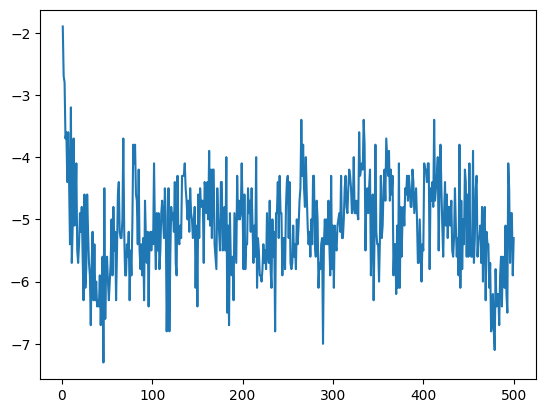

                                    Time          
                            ──────────────────────
      Tot / % measured:          19.9s / 99.4%    

 Section            ncalls     time   %tot     avg
 ─────────────────────────────────────────────────
 construct loop        500    19.6s  98.8%  39.2ms
 make vertex list      500    205ms  1.04%   411μs
 loop update           500   20.6ms  0.10%  41.1μs
 check update          500   3.37ms  0.02%  6.75μs
 diag update           500   2.78ms  0.01%  5.55μs
 ─────────────────────────────────────────────────
-5.20990099009901


In [41]:
using TimerOutputs

# Initialize parameters

# temperature
β = 10

# number of sites
Nsites = 8

# starting number of max op string
MaxM = 2000
M = 40 #Nsites*2
n = 0


a = zeros(Int,MaxM)
b = zeros(Int,MaxM)
opstring = zeros(Int,MaxM)

spin = [(i-0.5)/abs(i-0.5) for i in rand(Nsites)]
# Check for unlikely cases
if sum(abs.(spin)) == Nsites
    spin[Nsites÷2] *= spin[Nsites÷2]
end
phase = 1
# for i in 1:Nsites
#     spin[i] = phase*-1
#     phase *= -1
# end
bsites = makeBsites(Nsites)
print("spin = ",spin,"\n")

maxMCsteps = 500
# ratio for MaxM vs n
α = 3

to = TimerOutput()

mlist = []
counterlist = []
countn = []
mcsteps = 0
while mcsteps < maxMCsteps
    
          
    # 1. do diagonal updates
    n = @timeit to "diag update"  diagUpdate!(a,b,opstring,spin,bsites,n,M,Nsites,β)
    
    if n <= 0
        continue
    end
        
    
    if M - n < n/α 
        prevM = M
        M = trunc(Int,n + n/α)
    end
    
    push!(mlist,M)
    push!(countn,-n/(β))
    
        
    # 2. construct vertexlist
    vlist, crossed_bonds, crossed_spins = @timeit to "make vertex list" makeVertexListSimple(a,b,bsites,Nsites,M)
  
    mcsteps += 1   
    push!(counterlist,mcsteps)

   
    # 3. construct all loops and flip
    loops, crossed_spins = @timeit to "construct loop" constructAllLoops(vlist,crossed_bonds,crossed_spins,bsites,M)

    
    if loops == -1 || size(loops)[1] == 0
        continue
    end
   
    # 4. do loop update
    @timeit to "loop update" loopUpdate!(loops,a,b,opstring,spin,bsites,crossed_bonds,crossed_spins)
    
   if !@timeit to "check update" checkConsistency(a,b,bsites,spin,Nsites)
       break;
   end

end

show(to; allocations = false)

#using Statistics, Distributions, StatsPlots
#plot(counterlist,mlist);
#plot(counterlist[1:M],countn[1:M]);
#plot([idxmax,idxmax],[0,M]);
#print("\n maxn=",maxn,"\t","idmaxn=",idxmax," varn=",varn,"\n")
#dimcountn = size(countn)[1]
PyPlot.plot(counterlist, countn);
meann = mean(countn[400:end])
print("\n",meann,"\n")